# ReqSys hw solution
    author: Oleg Naidovich
    
    
# Abstract

The main idea of this approach is simple. 

0. Gathering data:
    * data was evaluated from UB and random approaches.
    * After gathering data I evaluated scores for user-based approach (T1) and lightfm approach (T2). 
    * In treatment T3 we will see our scores.
  
1. Let's create embeddings for all users and all items based on DNN.
    * data = pairs of (user, item, time) 
    * X_input = embeddings for user & item pairs
    * y_input = time that user has spent on item
    * metric: mae
    * loss = mse error
    
In addition to that we could solve this with classification problem: create rool when time > 0.8 => target = 1 else 0 

2. Use embeddings for creating interaction matrix
    * interaction = np.matmul(user_embeddings, item_embeddings.T)
    
3. Return top_k values for each user
    * sort interaction matrix for each user and get top_k values
    
    Some userful discoveries: 
        * best embedding size ~= 25
        * based on some experiments with top_k predictions we can conclude that best top_k ~= **20-30 values**
        * mean number of listened songs is around ~= 6-7 songs per session per user with user-based recommendations approach. So we don't need to provide too much top_k predictions. (yea, with higher probability we will have more repeated songs, but for the future we can create ranking for our system)        

In [160]:
from collections import namedtuple

import pandas as pd
import numpy as np
import sklearn.metrics as sm

import tqdm
import json

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

from pytorch_lightning.accelerators import MPSAccelerator

# Regression approach

## Gathering data

In [2]:
data = pd.read_json('log/train_data.json', lines=True)

In [3]:
print(data.shape)
data.head(5)

(317470, 8)


,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-10 13:34:06.832,9487,32315,1.0,0.004714,45279.0,{'USER_BASED': 'C'}
1,next,2023-04-10 13:34:06.836,9487,32315,1.0,0.000285,24275.0,{'USER_BASED': 'C'}
2,next,2023-04-10 13:34:06.837,9487,32315,1.0,0.000258,34923.0,{'USER_BASED': 'C'}
3,next,2023-04-10 13:34:06.838,9487,32315,1.0,0.000304,49747.0,{'USER_BASED': 'C'}
4,next,2023-04-10 13:34:06.842,9487,45279,0.0,0.000318,28536.0,{'USER_BASED': 'C'}


In [4]:
features = ['user', 'track']
Pair = namedtuple("Session", ["user", "track", "time"])


def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        pairs.append(Pair(row["user"], row["track"], row["time"]))
    return pairs


def get_train_val_test(data, train_size=0.85):
    test_size = (1 - train_size) / 2 
    rdm = np.random.random(len(pairs))

    train_data = data[rdm < train_size]
    val_data = data[(rdm >= train_size) & (rdm < train_size + test_size)]
    test_data = data[rdm >= train_size + test_size]

    print(f'{len(train_data)=}, {len(val_data)=}, {len(test_data)=},')
    return train_data, val_data, test_data

In [5]:
pairs = pd.DataFrame(
    data
    .groupby('user')
    .apply(get_pairs)
    .explode()
    .values
    .tolist()
)

In [6]:
pairs.head(5)

,user,track,time
0,0,34788,1.0
1,0,36365,0.0
2,0,1251,0.0
3,0,9440,0.0
4,0,39890,0.0


In [7]:
values = pd.DataFrame(data.groupby(['user', 'message'])['timestamp'].count())['timestamp'].values
lst = []
for a, b in zip(values[::2], values[1::2]):
    lst.append(b / a)
print(np.array(lst).mean())

# mean number of listened songs for each user

6.5872361985781716


In [8]:
train_data, val_data, test_data = get_train_val_test(pairs, train_size=0.8)


train_dataset = td.TensorDataset(
    torch.from_numpy(train_data[features].values), 
    torch.from_numpy(train_data["time"].values),
)

val_dataset = td.TensorDataset(
    torch.from_numpy(val_data[features].values), 
    torch.from_numpy(val_data["time"].values)
)

test_dataset = torch.from_numpy(test_data[features].values)


train_loader = td.DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0)
val_loader = td.DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)
test_loader = td.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0)

len(train_data)=253970, len(val_data)=31541, len(test_data)=31959,


## Model creation

In [16]:
class Ranker(pl.LightningModule):
    def __init__(self, embedding_dim=25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.user = nn.Embedding(10000, embedding_dim)
        self.track = nn.Embedding(50000, embedding_dim)

    def forward(self, x):
        user = self.user(x[:, 0])
        track = self.track(x[:, 1])
        return torch.sum(user * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [17]:
net = Ranker()
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss')

trainer = pl.Trainer(
    max_epochs=1000,
#     accelerator=MPSAccelerator(), 
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=10),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(net, train_loader, val_loader)


  | Name  | Type      | Params
------------------------------------
0 | user  | Embedding | 250 K 
1 | track | Embedding | 1.2 M 
------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00384: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00388: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00392: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
best = Ranker.load_from_checkpoint(checkpoint_callback.best_model_path)

## Evaluation

In [20]:
def get_metrics(model, data, loader, test=True):
    preds = []
    if test:
        for batch in loader:
            preds.extend(model(batch).detach().numpy().tolist())
    else:
        for batch, _ in loader:
            preds.extend(model(batch).detach().numpy().tolist())
    
    mse = sm.mean_squared_error(preds, data["time"])
    mae = sm.mean_absolute_error(preds, data["time"])

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

In [163]:
# train
get_metrics(best, train_data, train_loader, test=False)

/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


MSE: 0.35457886423526724
MAE: 0.35457886423526724


In [161]:
# val
get_metrics(best, val_data, val_loader, test=False)

MSE: 0.20394447584950695
MAE: 0.20394447584950695


/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


In [162]:
# test
get_metrics(best, test_data, test_loader, test=True)

MSE: 0.2045977011494253
MAE: 0.2045977011494253


/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


Results for **regression**.

Here we have 3 treatments: 
* t1 - user-based approach
* t2 - lightfm approach
* t3 - my approach

As we can see, our approach is slightly worse that lightfm's, but still better that user-based


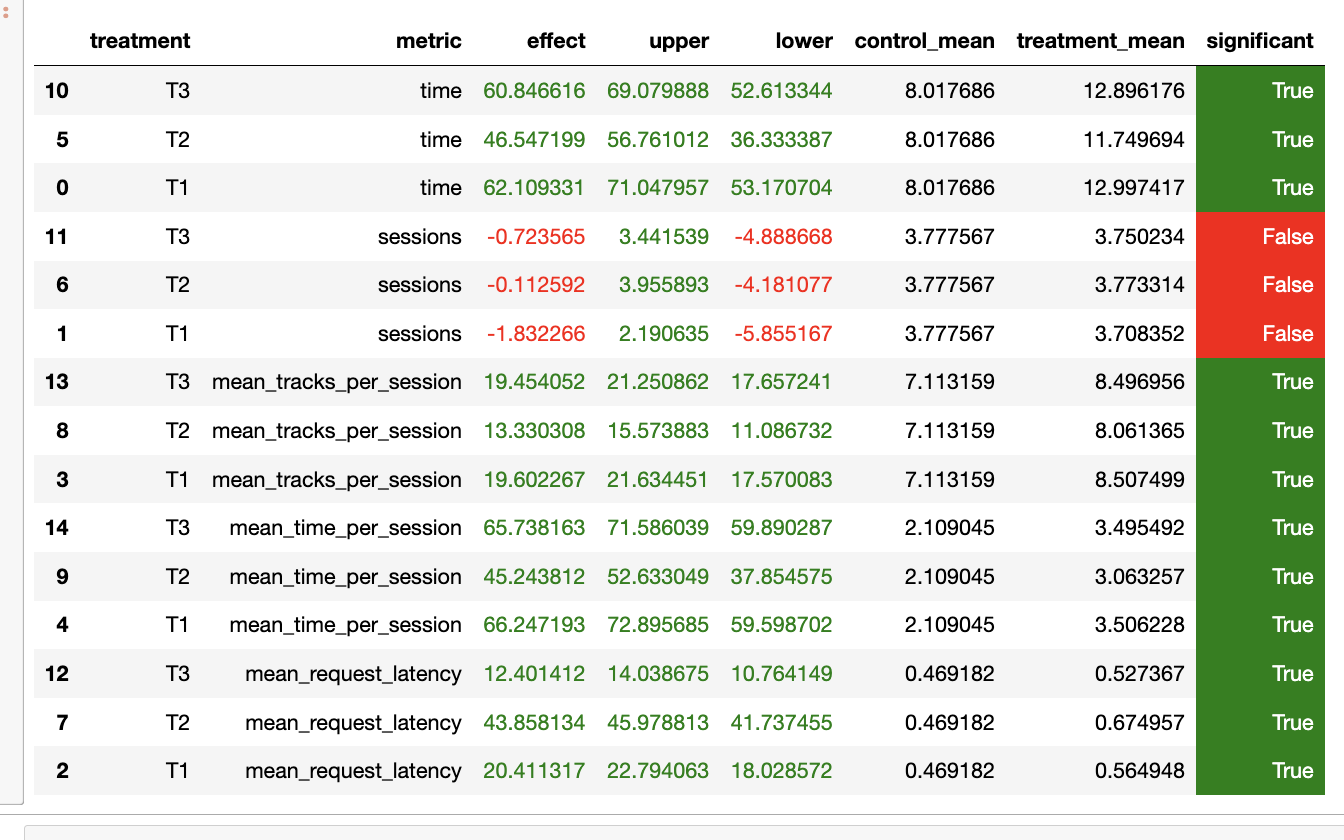

# Classification approach
## Gathering data

In [40]:
pairs = pd.DataFrame(
    data
    .groupby('user')
    .apply(get_pairs)
    .explode()
    .values
    .tolist()
)

<AxesSubplot:xlabel='time', ylabel='Count'>

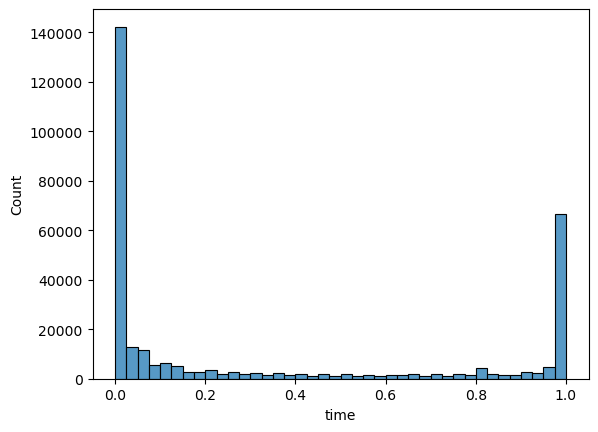

In [43]:
sns.histplot(pairs.time)

In [44]:
pairs['time'] = np.where(pairs['time'] > 0.8, 1, 0)

<AxesSubplot:xlabel='time', ylabel='Count'>

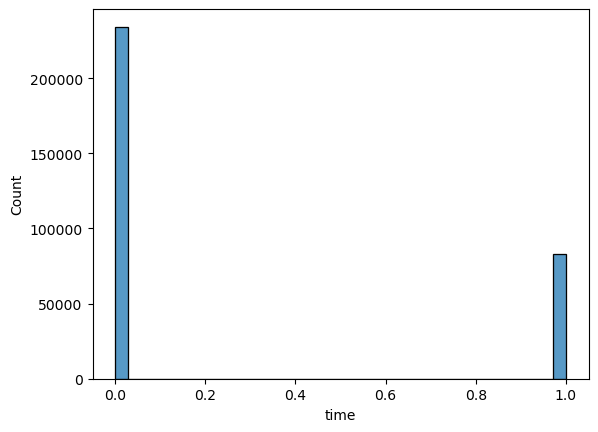

In [45]:
sns.histplot(pairs.time)

In [46]:
train_data, val_data, test_data = get_train_val_test(pairs, train_size=0.8)


train_dataset = td.TensorDataset(
    torch.from_numpy(train_data[features].values), 
    torch.from_numpy(train_data["time"].values),
)

val_dataset = td.TensorDataset(
    torch.from_numpy(val_data[features].values), 
    torch.from_numpy(val_data["time"].values)
)

test_dataset = torch.from_numpy(test_data[features].values)


train_loader = td.DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0)
val_loader = td.DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)
test_loader = td.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0)

len(train_data)=253873, len(val_data)=31842, len(test_data)=31755,


## Model creation¶

In [116]:
class Ranker(pl.LightningModule):
    def __init__(self, embedding_dim=25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.user = nn.Embedding(10000, embedding_dim)
        self.track = nn.Embedding(50000, embedding_dim)
        self.linear = nn.Linear(1, 2)

    def forward(self, x):
        user = self.user(x[:, 0])
        track = self.track(x[:, 1])
        total = torch.sum(user * track, dim=1, keepdim=True)
        return self.linear(total)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = nn.CrossEntropyLoss()(predictions, y)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [117]:
net = Ranker()
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss')

trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=10),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [118]:
trainer.fit(net, train_loader, val_loader)


  | Name   | Type      | Params
-------------------------------------
0 | user   | Embedding | 250 K 
1 | track  | Embedding | 1.2 M 
2 | linear | Linear    | 4     
-------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [119]:
best = Ranker.load_from_checkpoint(checkpoint_callback.best_model_path)

In [150]:
def get_metrics(model, data, loader, test=True):
    preds = []
    if test:
        for batch in loader:
            preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())
    else:
        for batch, _ in loader:
            preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())
    
    mse = sm.mean_squared_error(preds, data["time"])
    mae = sm.mean_absolute_error(preds, data["time"])

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

In [151]:
get_metrics(best, train_data, train_loader, test=False)

get_metrics(best, val_data, val_loader, test=False)

get_metrics(best, test_data, test_loader, test=True)

/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


MSE: 0.3537122892154739
MAE: 0.3537122892154739


/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


MSE: 0.20394447584950695
MAE: 0.20394447584950695
MSE: 0.2045977011494253
MAE: 0.2045977011494253


/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/3115974080.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.extend(nn.Softmax()(best(batch)).argmax(dim=1).detach().numpy().tolist())


Results for **classification**.

Here we have 3 treatments: 
* t1 - user-based approach
* t2 - lightfm approach
* t3 - my approach

As we can see, our approach is the worst one, so it is better to solve this task as regression


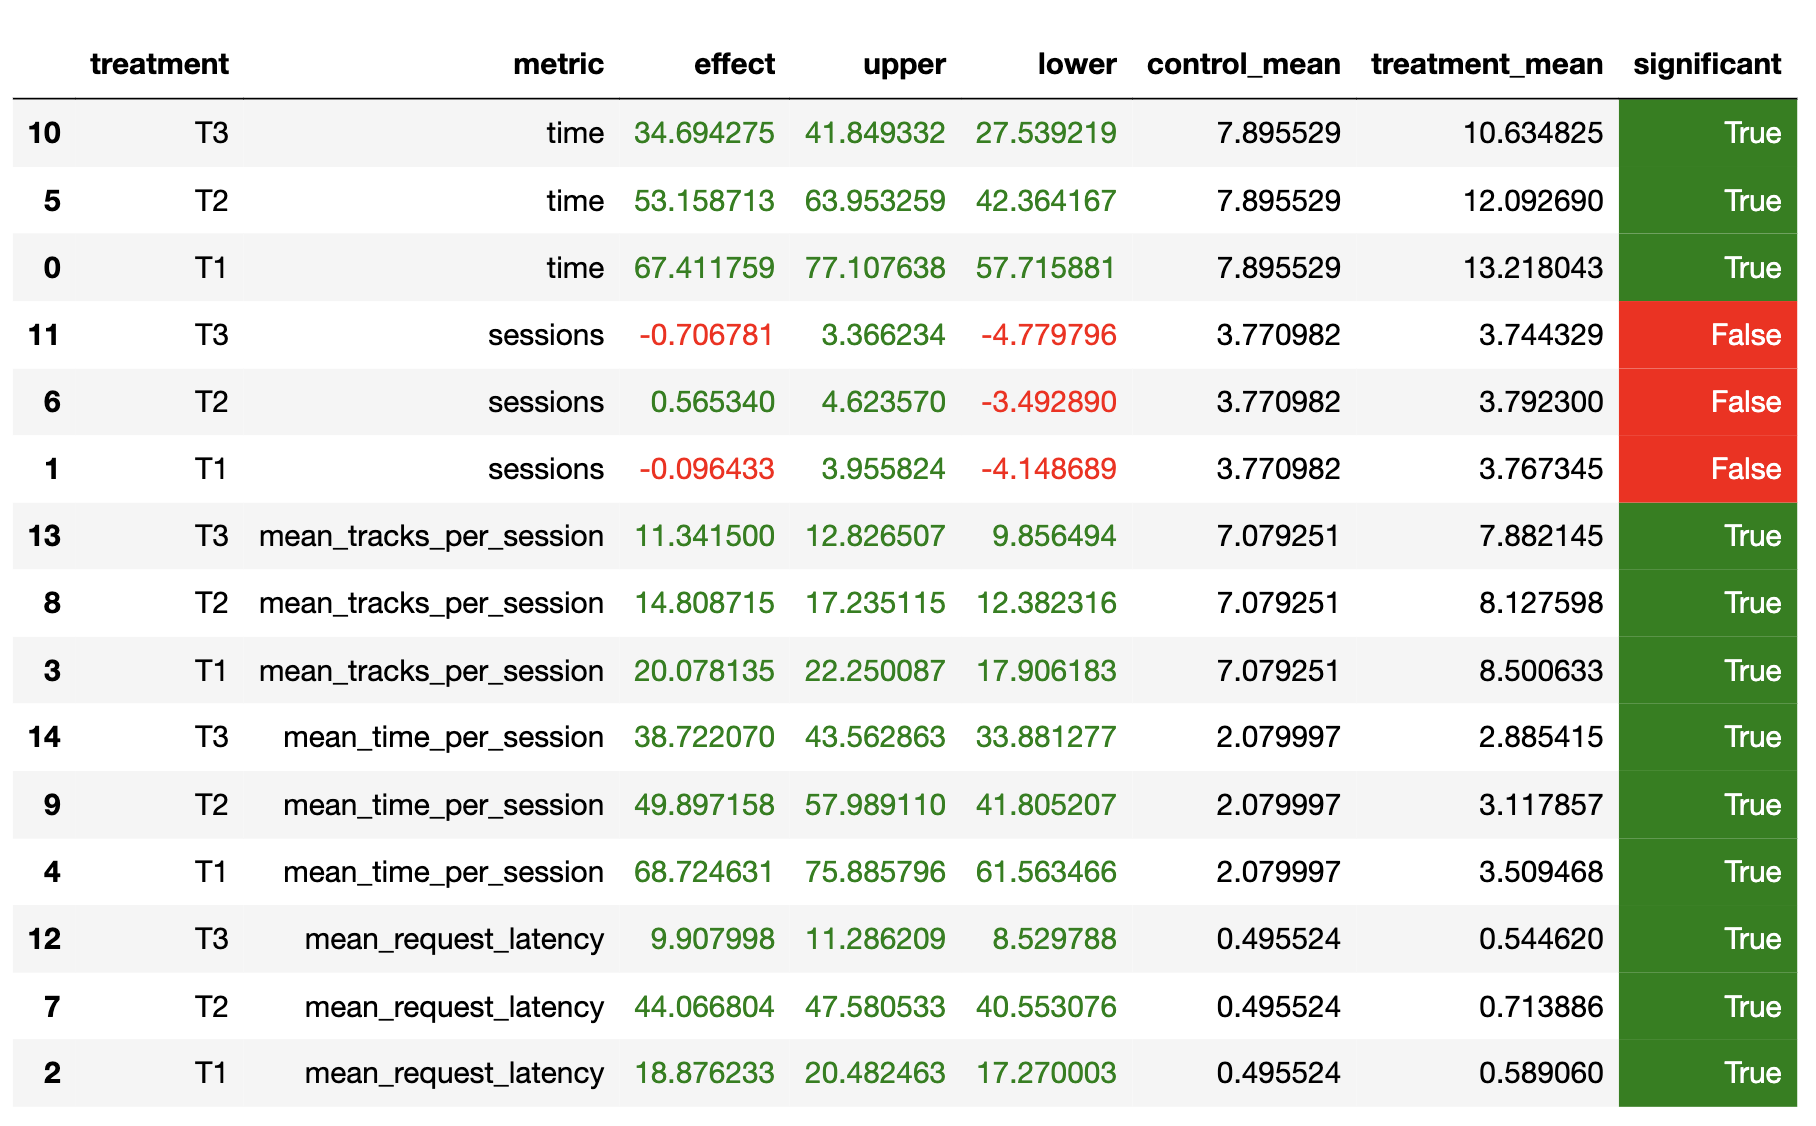

# Creation of interaction matrix with user-item embs

In [152]:
user_embeddings = dict(best.named_parameters())["user.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [153]:
interaction = np.matmul(user_embeddings, track_embeddings.T)

In [154]:
interaction = pd.DataFrame(interaction, columns=np.arange(50000), index=np.arange(10000))

In [155]:
interaction.shape

(10000, 50000)

In [156]:
users = data["user"].unique()
top_k = 25

In [157]:
def recommend(user_id, scores, k):
    return scores.loc[user_id].sort_values(ascending=False)[:k].index.tolist()

In [158]:
with open("recommendations_my.json", "w") as rf:
    for user in tqdm.tqdm(users):
        recommendation = {
            "user": int(user),
            "tracks": recommend(user, interaction, top_k)
        }
        rf.write(json.dumps(recommendation) + "\n")

  0%|                                                                                                                                                                                  | 0/9256 [00:00<?, ?it/s]/var/folders/1d/1ltz4mh92w75fs8jnyghsh900000gn/T/ipykernel_90846/2580860939.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return scores.loc[user_id].sort_values(ascending=False)[:k].index.tolist()
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9256/9256 [00:36<00:00, 251.14it/s]


# Final

This is a final table from regression approach



As a resolt our approach positively affects on such metrics **as mean_time_per_session by 65% !!** than random...
Not the best of the best, but at least it works.


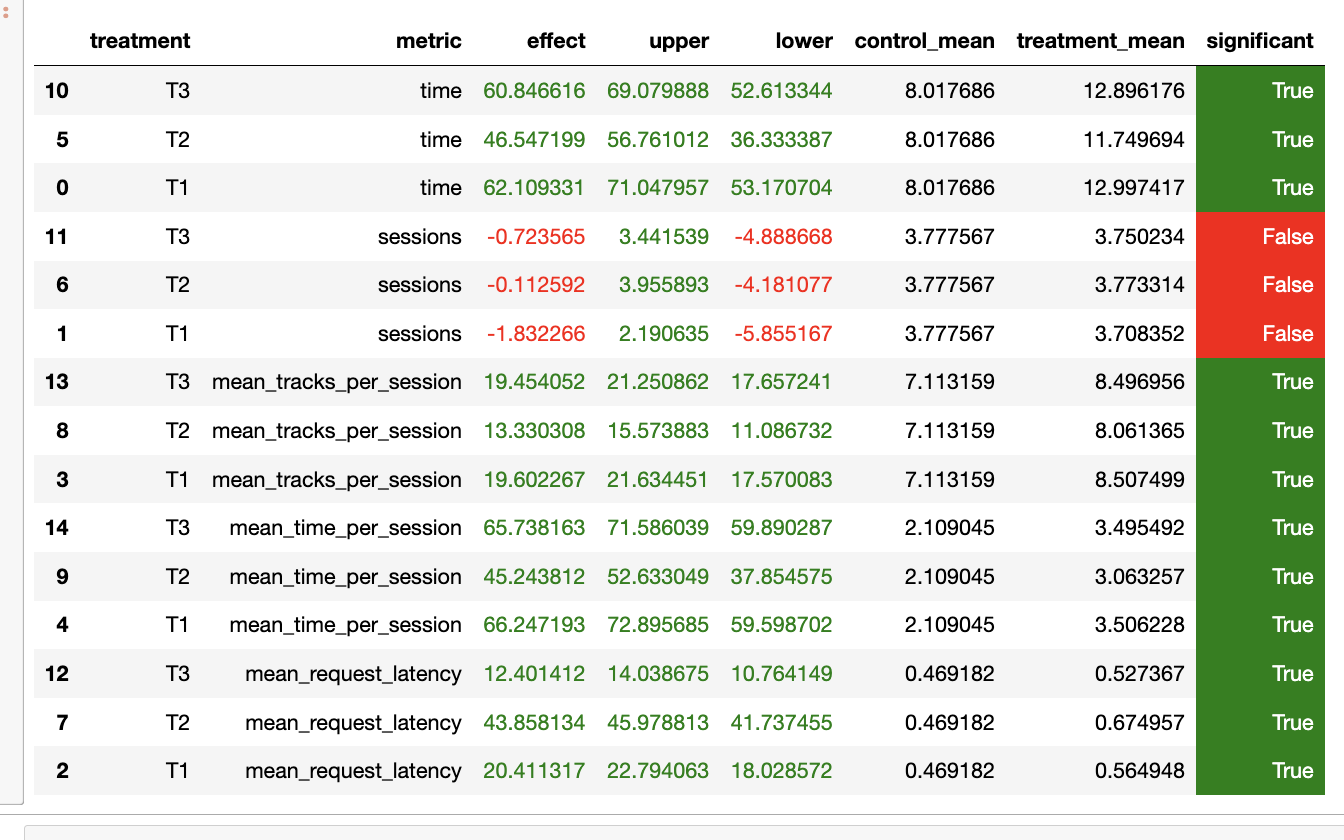

# final (update 22.05)

Comparing CONTEXTUAL method with outs approach, UB and light_fm approach we can conclude that:
1. our approach (T3) slightly worse than UB (T1) but at least it is better than lightFM. 
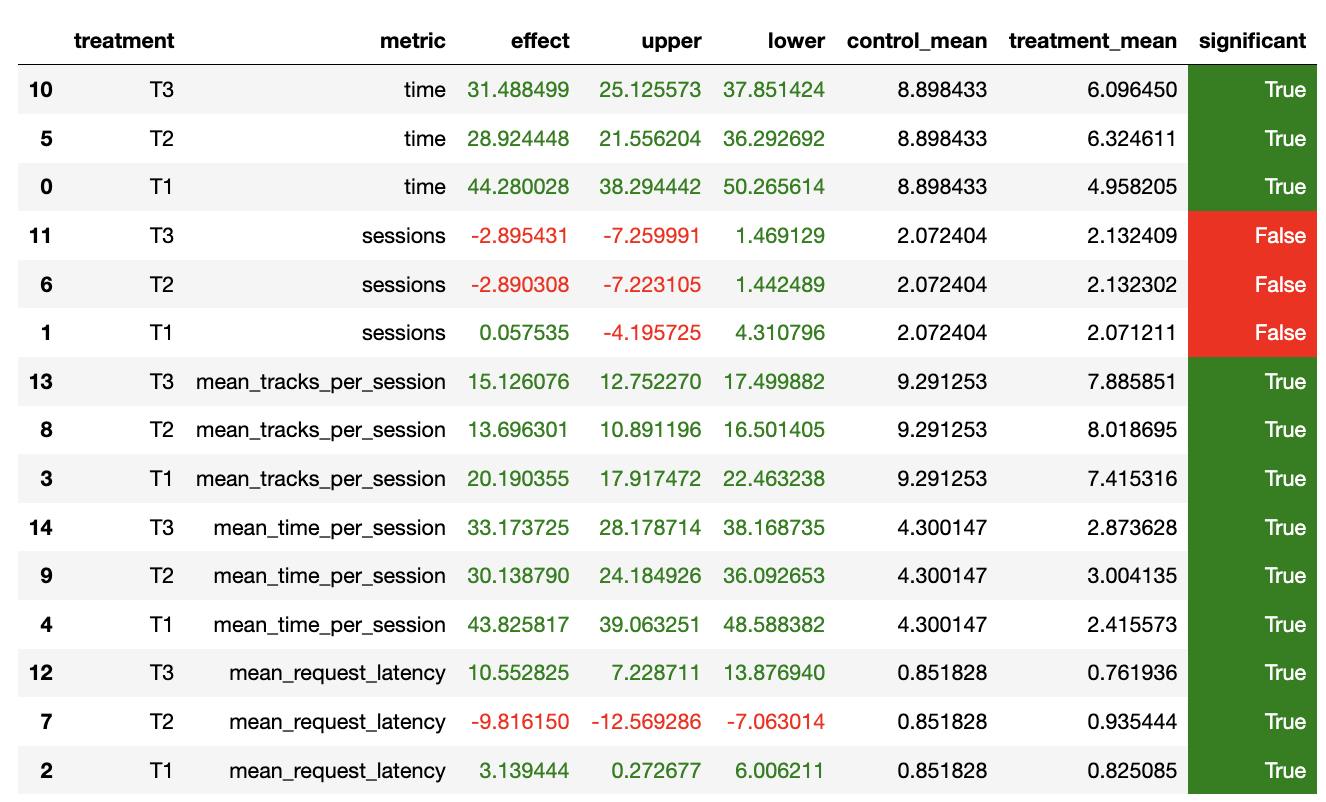

# Experimens with different top_k and size and emb

**Here I was checking how the number of recommendations affect on user experience**

Outputs with params:

1. emb = 25
* t1: TOP 10
* t2: TOP 25
* t3: TOP 50

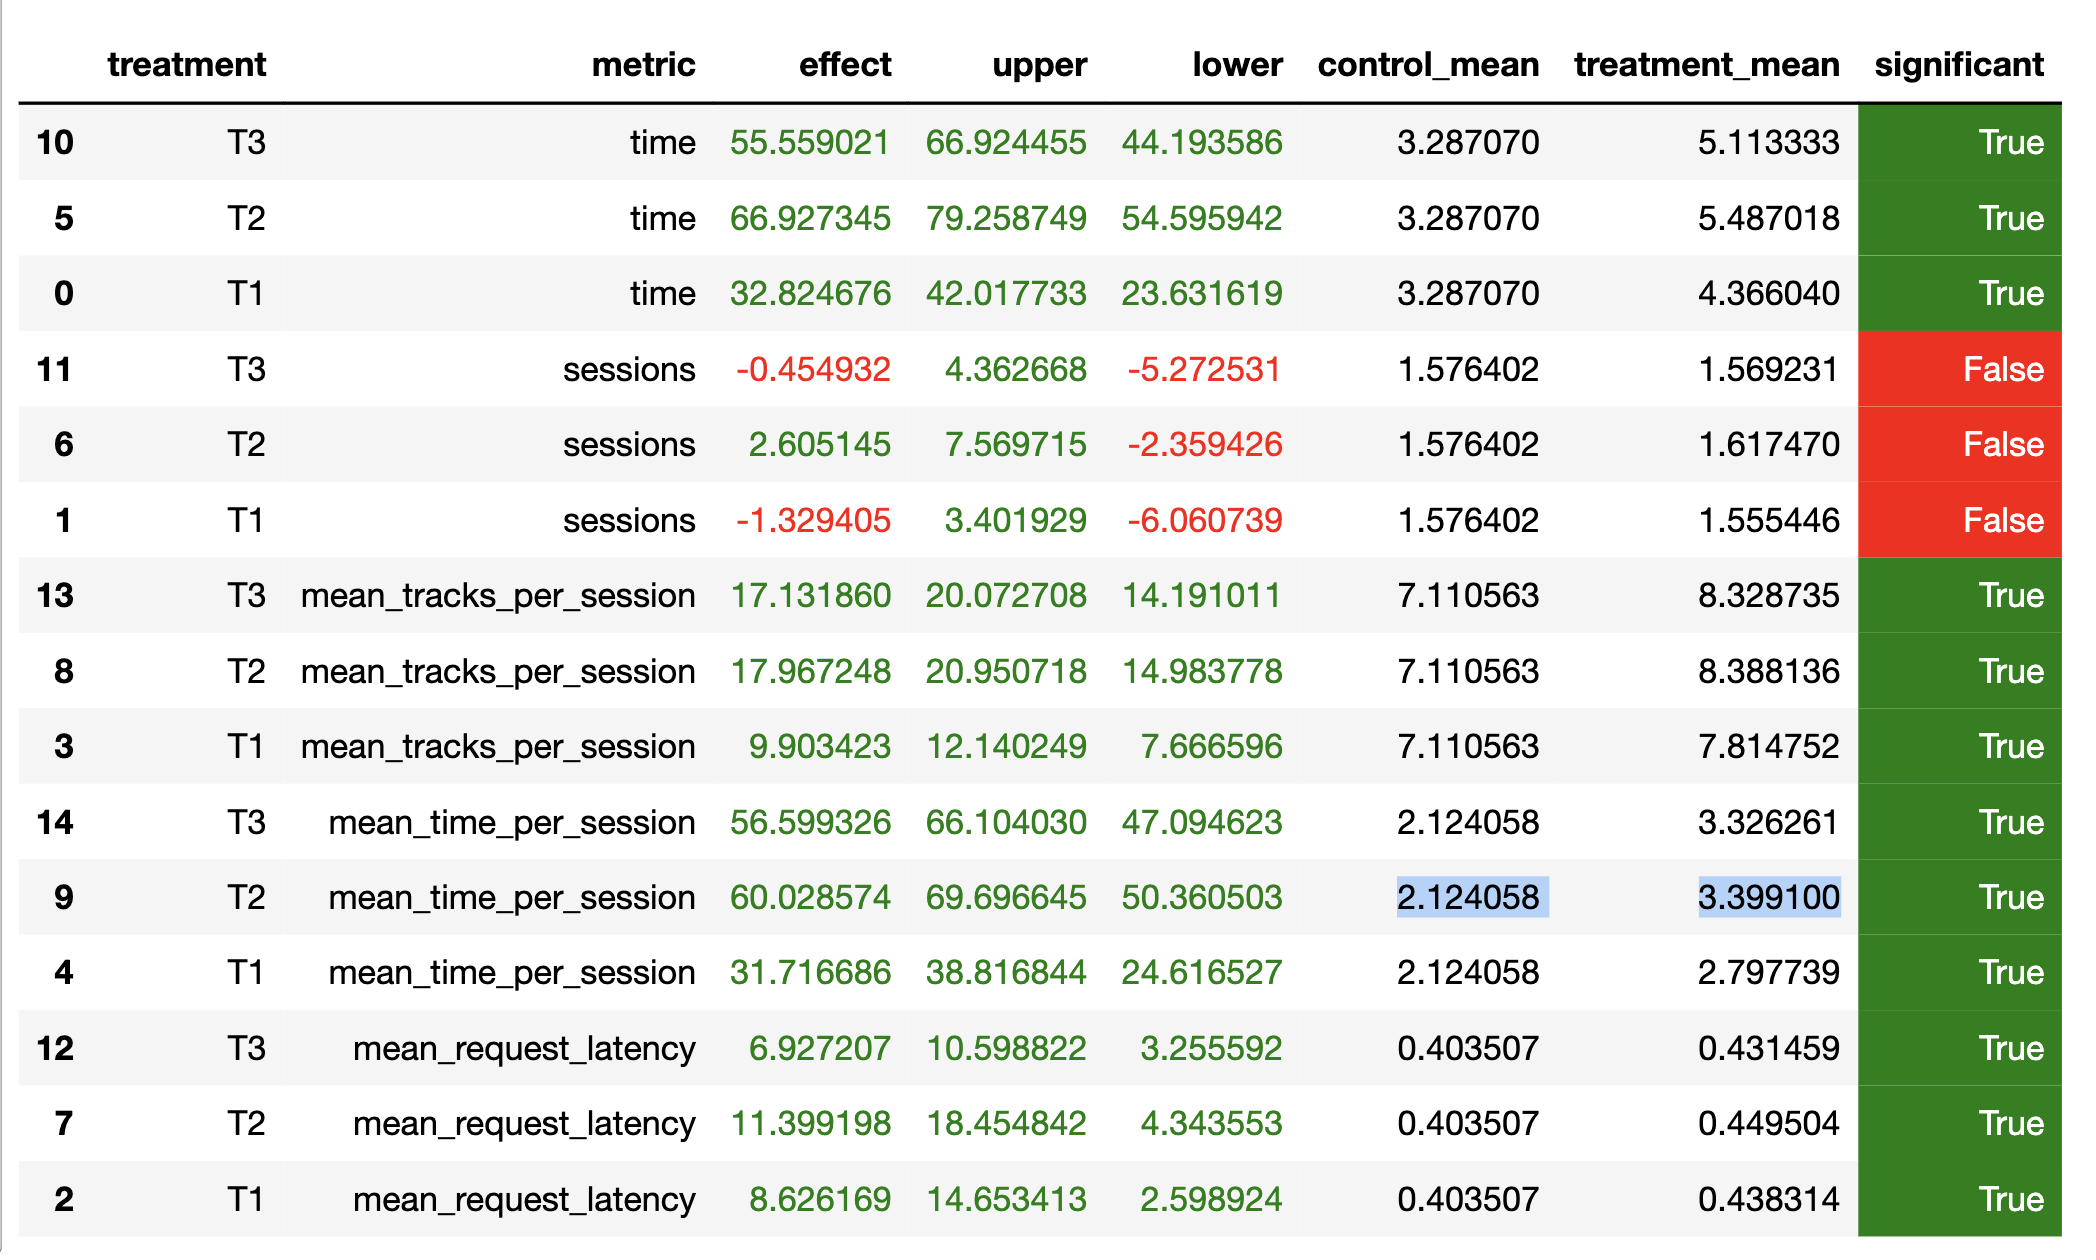
